# Fire Spread Model - Quick Start

This notebook demonstrates the **Fire Spread Model**, a classic example showcasing ABSESpy's spatial modeling capabilities.

> **📁 Location**: `examples/fire_spread/fire_quick_start.ipynb`  
> **📝 Full Model**: `examples/fire_spread/model.py`  
> **📚 Complete Tutorial**: `docs/tutorial/completing/fire_tutorial.ipynb`  
> **⚙️ Configuration**: `examples/fire_spread/config.yaml`

## Features Demonstrated

- `@raster_attribute`: Mark properties as spatial data
- `PatchCell`: Spatial cells with state management  
- `ActorsList`: Batch operations on cells
- **Dynamic plotting**: `module.attr.plot()` - NEW!
- **Enum-based state management**: Pythonic state management
- **Built-in run methods**: `model.run_model(steps=N)`

## Model Overview

The fire spreads through a forest grid where each cell can be:
- **EMPTY**: No tree (black)
- **INTACT**: Healthy tree (green)  
- **BURNING**: Currently on fire (orange)
- **SCORCHED**: Burned, cannot burn again (red)


## 1. Import and Setup


In [1]:
import hydra

# Import the model from local directory
from model import Forest, Tree

# Load configuration from config.yaml using Hydra
# This matches how model.py loads its configuration
with hydra.initialize(config_path=".", version_base=None):
    cfg = hydra.compose(config_name="config")

## 2. Create and Run a Simple Simulation


In [2]:
model = Forest(parameters=cfg)

# Print model information
print(f"Grid size: {model.nature.shape2d}")
print(f"Total cells: {model.nature.width * model.nature.height}")
print(f"Number of trees: {model.num_trees}")
print(f"Initial burn rate: {model.burned_rate:.2%}")

2025-10-27 12:48:23.577 | INFO     | abses.space.patch:__init__:275 - Initializing a new Model Layer...


Grid size: (100, 100)
Total cells: 10000
Number of trees: 7000
Initial burn rate: 0.00%


## 3. Visualize Initial State with NEW Dynamic Plotting


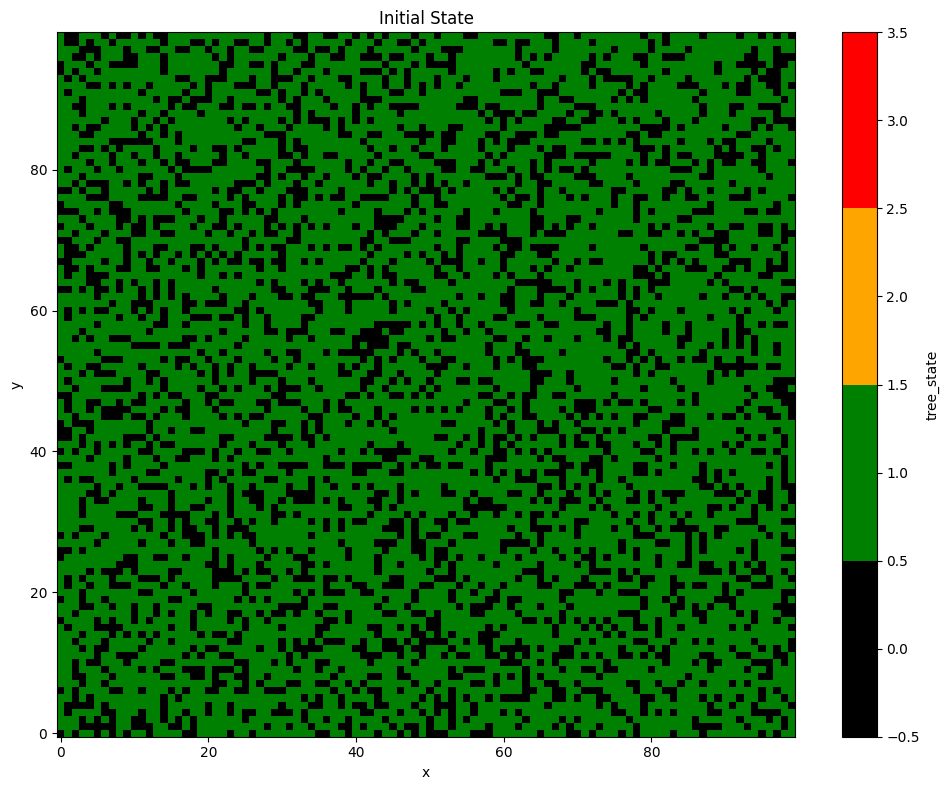

In [3]:
# Use the NEW dynamic plotting feature!
color_map = {
    Tree.State.EMPTY: "black",
    Tree.State.INTACT: "green",
    Tree.State.BURNING: "orange",
    Tree.State.SCORCHED: "red",
}

# Plot using the fluent API - just access the attribute and call .plot()!
model.nature.tree_state.plot(cmap=color_map, title="Initial State");

## 4. Run Simulation and Track Progress


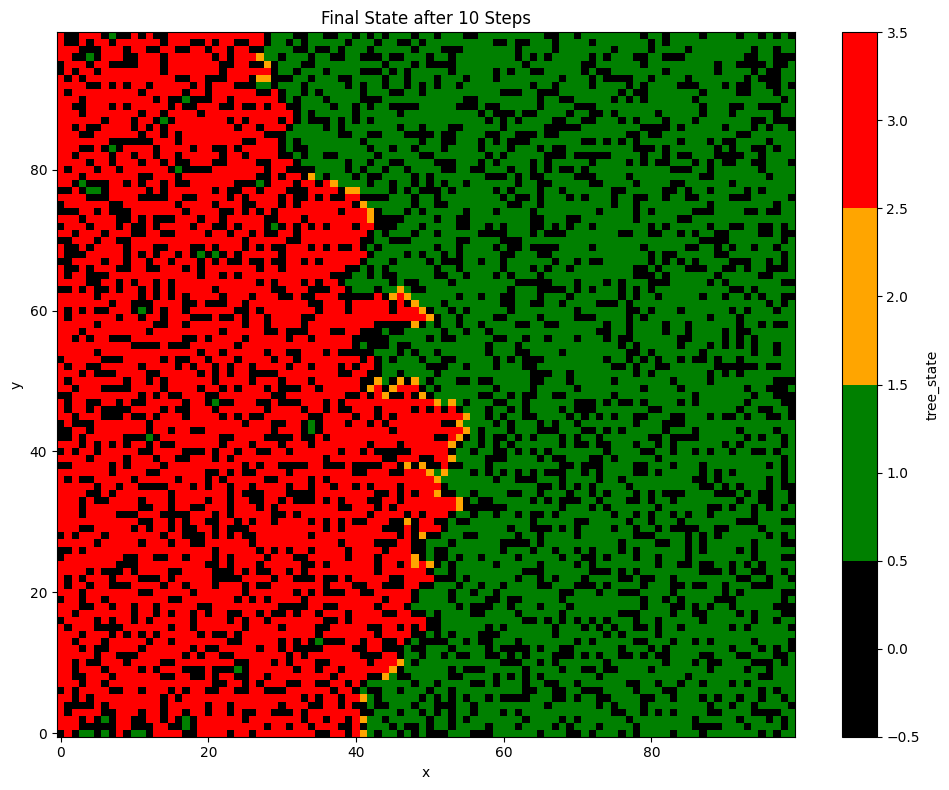

Final burn rate: 42.56%


In [4]:
# Use ABSESpy's built-in run_model method to run simulation
# Just run for 10 steps at once!
model.run_model(steps=30)

# Plot final state
model.nature.tree_state.plot(cmap=color_map, title="Final State after 10 Steps")

print(f"Final burn rate: {model.burned_rate:.2%}")

## 5. Experiment on parameters

**Experimental Design:**

This experiment will test how the final burn rate changes with forest density, demonstrating a classic non-linear pattern:

- **Low density**: Fire cannot spread (trees are too far apart)
- **Medium density**: Fire spreads rapidly (optimal connectivity)  
- **High density**: Fire spreads but may burn out faster (crowding effect)

We'll test 9 density values from 0.1 to 0.9, running 3 repeats for each to ensure statistical robustness.


# Import the Experiment class
from abses import Experiment

# Create an experiment with the Forest model
exp = Experiment.new(
    model_cls=Forest,
    cfg=cfg,
    seed=42,  # Set a base seed for reproducibility
)

# Define density values to test (from sparse to dense)
densities = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

print("Running batch experiments to test how burn rate varies with forest density...")
print(f"Testing {len(densities)} density values: {densities}")

# Run experiments with different density values
exp.batch_run(
    overrides={"forest.density": densities},
    repeats=3,  # Run each configuration 3 times for statistical robustness
    parallels=4,  # Use 4 parallel processes
)

print("\nExperiments completed! Analyzing results...")


In [5]:
from abses import Experiment

densities = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

exp = Experiment.new(Forest, cfg)
exp.batch_run(
    overrides={"model.density": densities},
    repeats=3,
    parallels=4,
)

9 jobs (repeats 3 times each).:   0%|          | 0/9 [00:00<?, ?it/s]

2025-10-27 12:48:29.558 | INFO     | abses.space.patch:__init__:275 - Initializing a new Model Layer...
2025-10-27 12:48:29.558 | INFO     | abses.space.patch:__init__:275 - Initializing a new Model Layer...
2025-10-27 12:48:29.559 | INFO     | abses.space.patch:__init__:275 - Initializing a new Model Layer...
2025-10-27 12:48:31.270 | INFO     | abses.space.patch:__init__:275 - Initializing a new Model Layer...
2025-10-27 12:48:31.282 | INFO     | abses.space.patch:__init__:275 - Initializing a new Model Layer...
2025-10-27 12:48:33.069 | INFO     | abses.space.patch:__init__:275 - Initializing a new Model Layer...
2025-10-27 12:48:34.888 | INFO     | abses.space.patch:__init__:275 - Initializing a new Model Layer...
2025-10-27 12:48:34.914 | INFO     | abses.space.patch:__init__:275 - Initializing a new Model Layer...
2025-10-27 12:48:34.920 | INFO     | abses.space.patch:__init__:275 - Initializing a new Model Layer...
2025-10-27 12:48:37.174 | INFO     | abses.space.patch:__init__:

### Detailed Results


In [6]:
results = exp.summary()
results.head()

,job_id,repeat_id,model.density,burned_rate
0,0,1,0.1,0.0060
1,0,2,0.1,0.0110
2,0,3,0.1,0.0110
3,1,1,0.2,0.0170
4,1,2,0.2,0.0185


<Axes: xlabel='model.density', ylabel='burned_rate'>

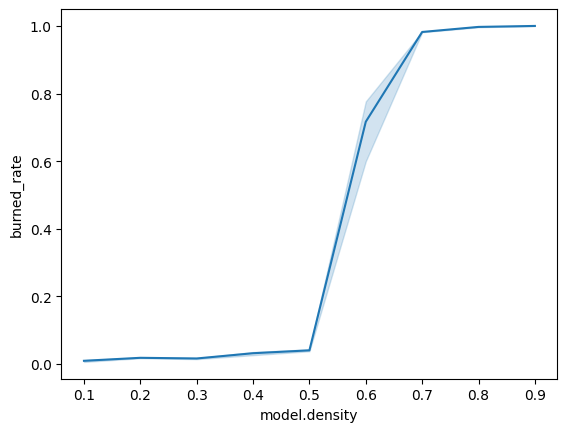

In [10]:
import seaborn as sns

sns.lineplot(x="model.density", y="burned_rate", data=results)